In [2]:
# %%
# import tqdm as notebook_tqdm 

import torch
import torch.nn as nn
from torch.optim import AdamW
# from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

import numpy as np
import unicodedata
import pandas as pd

from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix

import transformers
from transformers import AutoTokenizer, AutoModel

import matplotlib.pyplot as plt


In [3]:
# %% [markdown]
# ### Preprocessing of data
# 1. Text to lowercase
# 2. Remove accents
#
# Ένας υπέροχος ποιητής -> ενας υπεροχος ποιητης


# %%
def strip_accents_and_lowercase(s):
    if type(s) == str:
        return ''.join(c for c in unicodedata.normalize('NFD', s)
                       if unicodedata.category(c) != 'Mn').lower()



In [4]:
# %%
transformers.logging.set_verbosity_error(
)  #δεν εχει λειτουργία κανει supress καποια warnings

# Load model and tokenizer
tokenizer_greek = AutoTokenizer.from_pretrained(
    'nlpaueb/bert-base-greek-uncased-v1')
lm_model_greek = AutoModel.from_pretrained(
    'nlpaueb/bert-base-greek-uncased-v1', return_dict=False) 


In [5]:
# %%
df: pd.DataFrame = pd.read_csv('../Dataset/greek.csv', delimiter=';')
df = df.dropna()  # removes None values


In [6]:
# %%
# Check that there are no nan values
assert df.isnull().values.any() == False


In [7]:
# %%
titles = df['title'].apply(strip_accents_and_lowercase)
labels = df['is_fake']


In [8]:
# %%
# check labels distribution
labels.value_counts(normalize=True)


0    0.547019
1    0.452981
Name: is_fake, dtype: float64

In [9]:
# %%
train_title, test_title, train_labels, test_labels = train_test_split(  #to Text ennoei ton titlo etsi?
    titles, labels, random_state=2022, test_size=0.3, stratify=labels)


<AxesSubplot: >

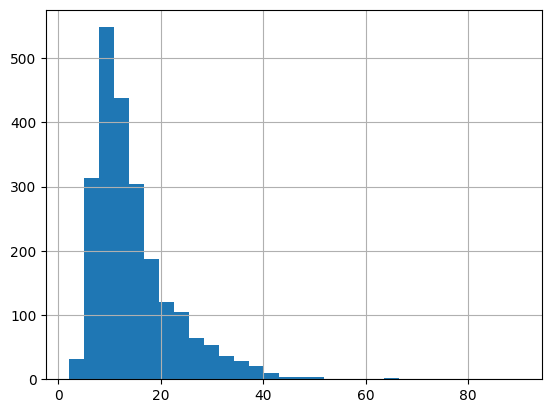

In [10]:
# %%
# Tokenizaion
# Get the length of all the titles in the train set
seq_len = [len(i.split()) for i in train_title]  # μέγεθος τίτλου σε λέξεις

pd.Series(seq_len).hist(bins=30)  # δημιουργία ιστογράμματος των μεγεθών


In [11]:
# %%
# define max sequence lenght (why?)
max_seq_len = 40


In [12]:
# %%
# tokenization and encoding of the sequences in the training and testing set
# truncation=True, -> limits token's len to max_seq_len
# for smaller tokens, pad with 0 until max_seq_len
tokens_train = tokenizer_greek.batch_encode_plus(train_title.tolist(),
                                                 max_length=max_seq_len,
                                                 padding='max_length',
                                                 truncation=True,
                                                 return_token_type_ids=False)

tokens_test = tokenizer_greek.batch_encode_plus(test_title.tolist(),
                                                max_length=max_seq_len,
                                                padding='max_length',
                                                truncation=True,
                                                return_token_type_ids=False)


In [13]:
# %%
# Convert Integer Sequences to Tensors

# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())  

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [14]:
# %%
batch_size = 64
epochs = 5 

# wrap tensors
# the TensorDataset is a ready to use class to represent our data as a list of tensors
train_data = TensorDataset(train_seq, train_mask, train_y) 

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data,
                              sampler=train_sampler,
                              batch_size=batch_size)


In [15]:
# %%
# Define the Model Custom Architecture
class BERT_Fake(nn.Module):

    def __init__(self, bert) -> None:
        super(BERT_Fake, self).__init__()

        self.bert = bert
        # DropoutLayer
        self.dropout = nn.Dropout(0.1)
        # ReLU
        self.relu = nn.ReLU()
        # Dense Layer 1
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, send_id, mask):
        # pass inputs to model
        _, cls_hs = self.bert(send_id, attention_mask=mask)

        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [16]:
# %%
# Pass the pre-trained BERT to our custom architecture
model = BERT_Fake(lm_model_greek)

# Push model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [17]:
optimizer = AdamW(model.parameters(), lr=1e-3)

In [18]:
# %%
# Compute the Class Weights
# With class weighting enabled, the sum is replaced by a weighted sum instead so that each sample contributes to the loss proportionally to the sample's class weight
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_labels),
                                     y=train_labels)


In [19]:
# %%
# Convert weights to tensors
weights = torch.tensor(class_weights, dtype=torch.float)
weigths = weights.to(device)

criterion = nn.NLLLoss(weight=weights)
criterion = criterion.to(device)


In [20]:
# %%
# writer = SummaryWriter('runs/greek-fake-news')



In [21]:
# %%
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    total_preds = []

    # Iterate over the batches
    for step, batch in enumerate(train_dataloader):
        # Update after every Number of batches
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step,
                                                       len(train_dataloader)))

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # Forward
        outputs = model(sent_id, mask)
        loss = criterion(outputs, labels)

        # Backward
        # Make the grads zero
        model.zero_grad()
        # Do the backward step of the loss calculation through chain derivatives
        total_loss = total_loss + loss.item()
        loss.backward()

        # Clip the gradients to 1.0. It helps in preventing the exploding gradient problem
        # TO TEST IT
        #torch.nn.utils.clip_grap_norm_(model.paremeters(),1.0)
        # Do the optimizer step and update the parameters
        optimizer.step()

        # Model predictions are stored on GPU. Push it to CPU
        outputs = outputs.detach().cpu().numpy()

        # Append the model predictions
        total_preds.append(outputs)

    # Compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # The predictions are in the form of (no. of batches, size of batch, no. of classes)
    # Reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # Return the loss and predictions
    return avg_loss, total_preds



In [22]:
# %%
# model training
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, preds = train()

    # To find out what happends with the accuracy per epoch
    # writer.add_scalar('Training Loss', train_loss, epoch)

    train_losses.append(train_loss)
    print(f'Training Loss: {train_loss:.3f}')
torch.save(model.state_dict(), 'saved_weights.pt')


Epoch 1 / 5
Training Loss: 0.745
Epoch 2 / 5


KeyboardInterrupt: 

In [ ]:
# %%
# writer.close()

path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))


In [ ]:
# %%
# Get Predictions for the Test Data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()



In [ ]:
# %%
def conf_to_metrics(conf):
    tn, fp, fn, tp = conf.ravel()

    accuracy = (tp + tn) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    fscore = 2 * sensitivity * precision / (sensitivity + precision)
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "fscore": fscore,
    }
    return metrics


In [23]:
torch.cuda.empty_cache()

In [ ]:
# %%
preds = np.argmax(preds, axis=1)


In [ ]:
# %%
conf = confusion_matrix(test_y, preds, labels=[0, 1])
conf_to_metrics(conf)


In [ ]:
# %%
# Plot ROC curve
auc_score = roc_auc_score(test_y, preds)
fpr, tpr, thresholds = roc_curve(test_y, preds, pos_label=1)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, 'b', label='AUC = %.2f' % auc_score)
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1 - Specificity')
ax.legend(loc='lower right')
nm = 'roc_curve' + str(round(auc_score, 3)) + '.svg'
fig.savefig(nm)


In [ ]:
# %%
print(classification_report(test_y, preds, target_names=['Fake', 'Real']))
